# SGD vs Batch GD - Comparative Analysis

Direct comparison of Stochastic vs Batch Gradient Descent:
1. Speed comparison
2. Convergence quality
3. Effect of dataset size
4. When to use each

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)
np.random.seed(42)


---
## Experiment 1: Speed Comparison

Size   100: Batch=0.0003s, SGD=0.0024s
Size   500: Batch=0.0004s, SGD=0.0119s
Size  1000: Batch=0.0004s, SGD=0.0235s
Size  5000: Batch=0.0008s, SGD=0.1221s


Size 10000: Batch=0.0013s, SGD=0.2485s


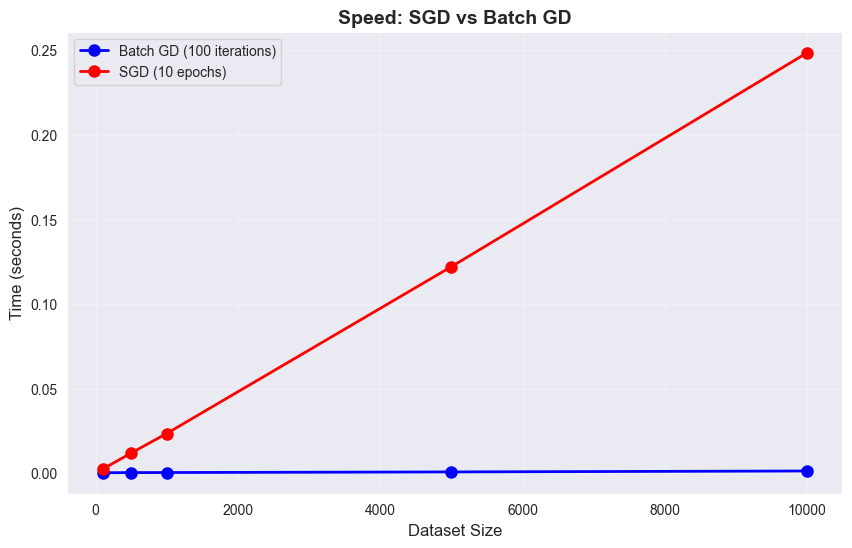

In [2]:
def compute_cost(X, y, theta):
    m = len(y)
    return (1/(2*m)) * np.sum((X.dot(theta) - y)**2)

def batch_gd(X, y, lr=0.1, n_iter=100):
    m = len(y)
    theta = np.zeros((X.shape[1], 1))
    
    start = time.time()
    for _ in range(n_iter):
        gradients = (1/m) * X.T.dot(X.dot(theta) - y)
        theta = theta - lr * gradients
    elapsed = time.time() - start
    
    return theta, elapsed

def sgd(X, y, lr=0.01, n_epochs=10):
    m = len(y)
    theta = np.zeros((X.shape[1], 1))
    
    start = time.time()
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        for i in indices:
            xi = X[i:i+1]
            yi = y[i:i+1]
            gradient = xi.T.dot(xi.dot(theta) - yi)
            theta = theta - lr * gradient
    elapsed = time.time() - start
    
    return theta, elapsed

# Test on different dataset sizes
sizes = [100, 500, 1000, 5000, 10000]
batch_times = []
sgd_times = []

for size in sizes:
    X = 2 * np.random.rand(size, 1)
    y = 5 + 3 * X + np.random.randn(size, 1)
    X_b = np.c_[np.ones((size, 1)), X]
    
    _, t_batch = batch_gd(X_b, y, n_iter=100)
    _, t_sgd = sgd(X_b, y, n_epochs=10)
    
    batch_times.append(t_batch)
    sgd_times.append(t_sgd)
    print(f'Size {size:5d}: Batch={t_batch:.4f}s, SGD={t_sgd:.4f}s')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, batch_times, 'b-o', linewidth=2, markersize=8, label='Batch GD (100 iterations)')
plt.plot(sizes, sgd_times, 'r-o', linewidth=2, markersize=8, label='SGD (10 epochs)')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Speed: SGD vs Batch GD', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Observation

- **Batch GD**: Time grows linearly with dataset size (processes all data each iteration)
- **SGD**: More consistent time (processes examples independently)
- **For large datasets**: SGD is much faster!

---
## Experiment 2: Convergence Quality

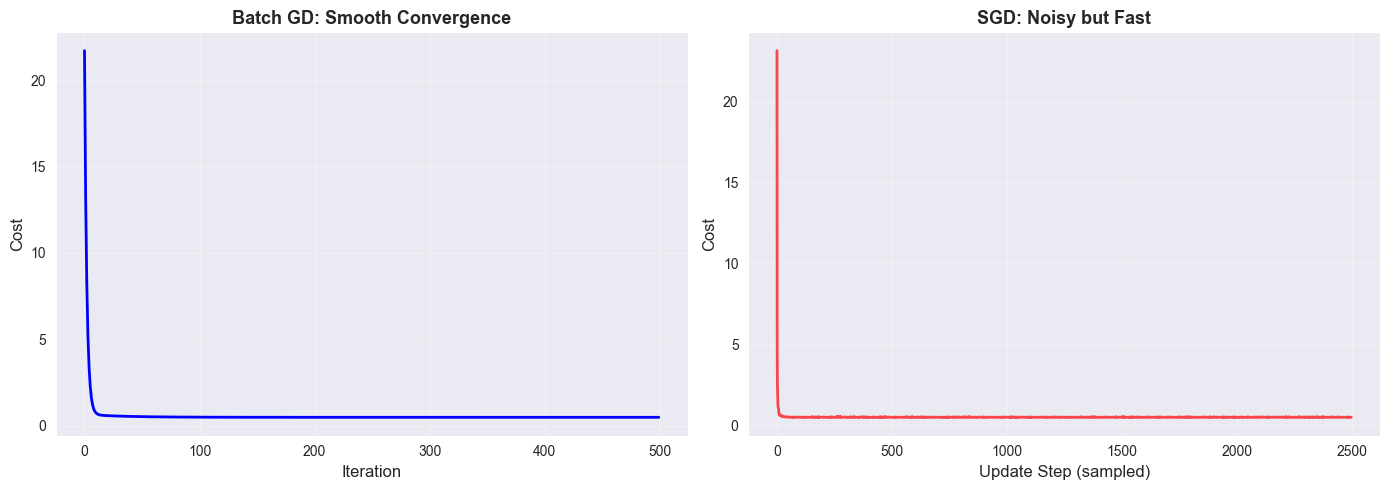

Batch GD final: θ = [4.89673275 3.13416657], cost = 0.484229
SGD final:      θ = [4.88853219 3.04505636], cost = 0.487385
True parameters: θ₀ = 5, θ₁ = 3


In [3]:
# Fixed dataset
m = 1000
X = 2 * np.random.rand(m, 1)
y = 5 + 3 * X + np.random.randn(m, 1)
X_b = np.c_[np.ones((m, 1)), X]

# Batch GD with cost tracking
def batch_gd_track(X, y, lr=0.1, n_iter=500):
    m = len(y)
    theta = np.random.randn(X.shape[1], 1)
    costs = []
    
    for _ in range(n_iter):
        gradients = (1/m) * X.T.dot(X.dot(theta) - y)
        theta = theta - lr * gradients
        costs.append(compute_cost(X, y, theta))
    
    return theta, costs

# SGD with cost tracking
def sgd_track(X, y, lr=0.01, n_epochs=50):
    m = len(y)
    theta = np.random.randn(X.shape[1], 1)
    costs = []
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        for i in indices:
            xi = X[i:i+1]
            yi = y[i:i+1]
            gradient = xi.T.dot(xi.dot(theta) - yi)
            theta = theta - lr * gradient
            
            if i % 20 == 0:  # Sample cost periodically
                costs.append(compute_cost(X, y, theta))
    
    return theta, costs

# Train both
theta_batch, cost_batch = batch_gd_track(X_b, y)
theta_sgd, cost_sgd = sgd_track(X_b, y)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cost_batch, linewidth=2, color='blue')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Cost', fontsize=12)
axes[0].set_title('Batch GD: Smooth Convergence', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(cost_sgd, linewidth=2, color='red', alpha=0.7)
axes[1].set_xlabel('Update Step (sampled)', fontsize=12)
axes[1].set_ylabel('Cost', fontsize=12)
axes[1].set_title('SGD: Noisy but Fast', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Batch GD final: θ = {theta_batch.ravel()}, cost = {cost_batch[-1]:.6f}')
print(f'SGD final:      θ = {theta_sgd.ravel()}, cost = {cost_sgd[-1]:.6f}')
print(f'True parameters: θ₀ = 5, θ₁ = 3')


---
## Experiment 3: Effect of Learning Rate

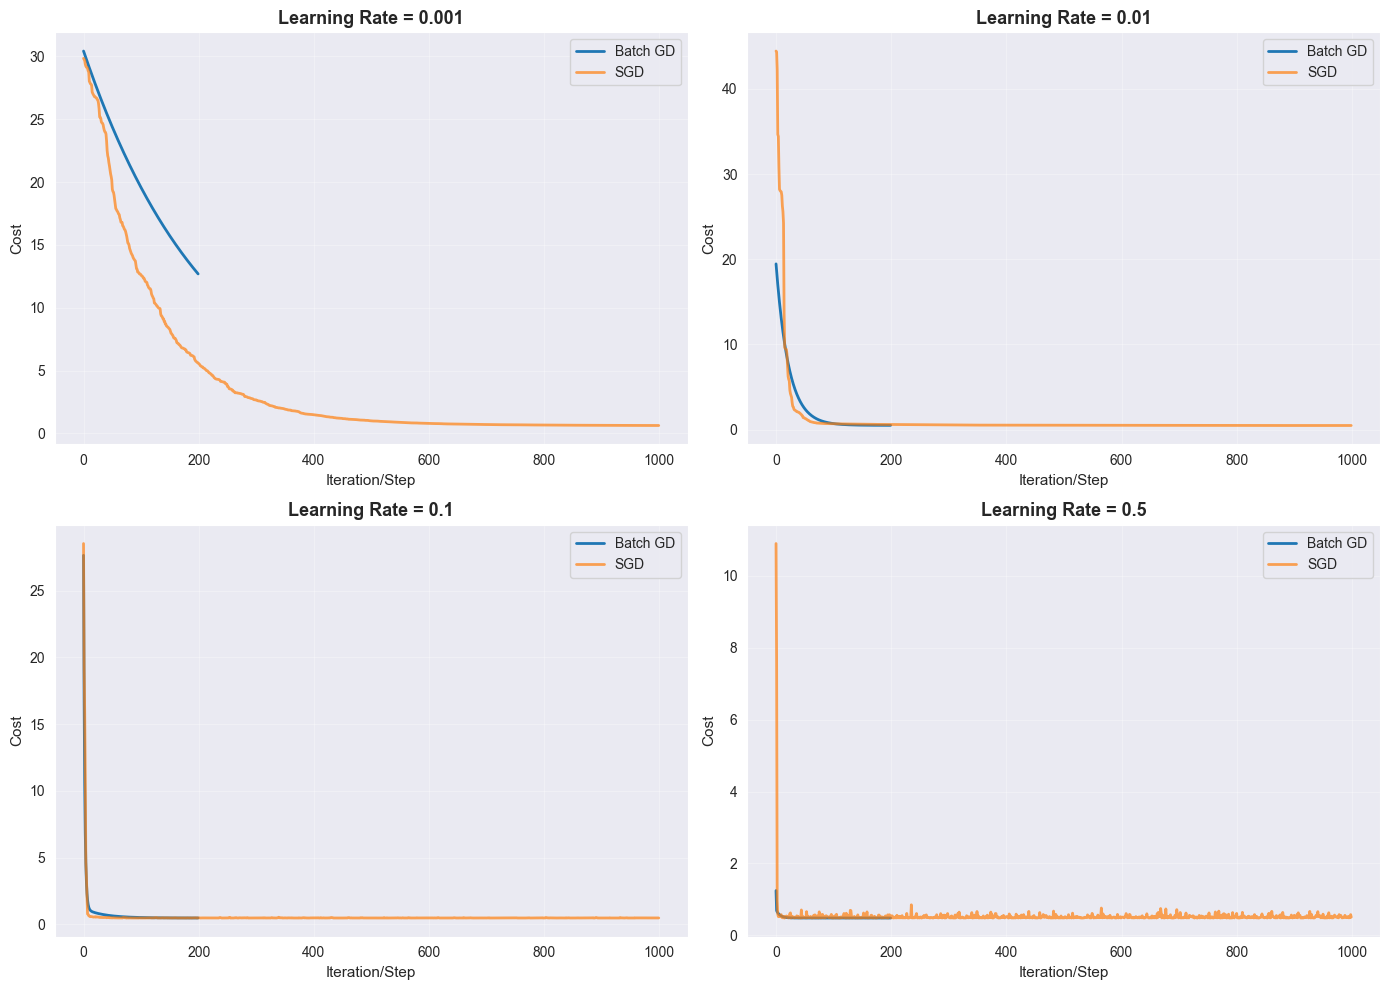

In [4]:
learning_rates = [0.001, 0.01, 0.1, 0.5]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, lr in enumerate(learning_rates):
    _, cost_batch = batch_gd_track(X_b, y, lr=lr, n_iter=200)
    _, cost_sgd = sgd_track(X_b, y, lr=lr/10, n_epochs=20)  # SGD needs smaller LR
    
    axes[idx].plot(cost_batch, label='Batch GD', linewidth=2)
    axes[idx].plot(cost_sgd, label='SGD', linewidth=2, alpha=0.7)
    axes[idx].set_title(f'Learning Rate = {lr}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Iteration/Step', fontsize=11)
    axes[idx].set_ylabel('Cost', fontsize=11)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Observation

- **Batch GD**: More tolerant to larger learning rates (uses exact gradient)
- **SGD**: Needs smaller learning rates (gradient is noisy)
- Rule of thumb: SGD learning rate ≈ 1/10 of Batch GD learning rate

---
## Decision Guide

### Use Batch Gradient Descent when:
- Dataset is small (< 10,000 examples)
- You need guaranteed convergence
- You're doing educational/theoretical work
- Memory is not a constraint

### Use Stochastic Gradient Descent when:
- Dataset is huge (millions of examples)
- Online learning (streaming data)
- Memory is limited
- You need fast initial progress

### Use Mini-Batch Gradient Descent when:
- Almost any practical application!
- Training neural networks
- You have GPU access
- You want balance of speed and stability

---

## Key Takeaways

1. **Speed**: SGD wins for large datasets
2. **Stability**: Batch GD has smoother convergence
3. **Final Quality**: Both reach similar solutions
4. **Learning Rate**: SGD needs smaller values
5. **Industry Standard**: Mini-batch (best of both worlds)

**Interview Tip**: Always mention mini-batch as the practical choice, but explain when you'd use the extremes (batch for small data, SGD for huge/streaming data).